# Shaw 2023
This looks at high percentiles of upper troposphere (200hPa) zonal wind, to see how they vary with warming. Shaw 2023 indicated that the fastest winds increase the most.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.convection import lapse_moist, equivalent_potential_temp
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, R, radius_earth, rot_earth
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2023-12-14 15:26:47,204 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'ucomp', 'height']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [32]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 200           # Desired approximate pressure of free troposphere (hPa)
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
season = 'all'
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

ds_all = []
# ds_unstack = []         # keep 'lon' and 'time' separate.
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        # ds_use = ds[i].sel(pfull=[np.inf, pressure_ft], method='nearest').sel(time=slice(use_time_start, np.inf))
        # Keep all pressure levels, so can do thermal wind calculation
        ds_use = ds[i].sel(pfull=slice(pressure_ft, np.inf)).sel(time=slice(use_time_start, np.inf))    
        ds_use = ds_use.isel(pfull=slice(None, None, -1))       # make surface pressure the first index
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        # ds_unstack += [ds_use]
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)
p_surface = float(ds_all[0].pfull[0]) * 100
pressure_ft_actual = float(ds_all[0].pfull[-1]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 2/2 [00:22<00:00, 11.17s/it]


In [5]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'midlat'
lat_min = 20
lat_max = 60
# Poles
# region = 'highlat'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

n_lat = ds_all[0].lat.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine
lat_use = np.where((np.abs(ds_all[0].lat) <= lat_max) & (np.abs(ds_all[0].lat) >= lat_min))[0]
lat_weights_use = lat_weights[lat_use]

### Get zonal wind speed as a function of quantile
`quant2` is absolute 200hPa zonal wind as a function of absolute 200hPa zonal wind percentile: $u(x_u)$.
`quant3` is absolute 200hPa zonal wind as a function of near-surface temperature percentile: $u(x_T)$.

In [6]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)

take_abs_u = True       # whether to consider speed or velocity of winds
if take_abs_u:
    u_func = lambda x: np.abs(x) 
else:
    u_func = lambda x: x

temp_mean = np.zeros((n_exp, n_lat))
u_mean = np.zeros((n_exp, n_lat))

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_lat, n_quant))
# upper troposphere zonal wind as function of u percentile
u_quant2 = np.zeros((n_exp, n_lat, n_quant))
# upper troposphere zonal wind as function of temperature percentile
u_quant3 = np.zeros((n_exp, n_lat, n_quant))

with tqdm(total=n_exp*n_quant*len(lat_use), position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp[0].mean(dim='lon_time', skipna=True)       # surface temp
        temp_quant2[i] = ds_all[i].temp[0].quantile(quant_plot/100, dim='lon_time', keep_attrs=True, skipna=True).transpose()
        
        u_mean[i] = u_func(ds_all[i].ucomp[-1]).mean(dim='lon_time', skipna=True)        # free trop u
        u_quant2[i] = u_func(ds_all[i].ucomp[-1]).quantile(quant_plot/100, dim='lon_time', keep_attrs=True, skipna=True).transpose()
        for k in range(n_lat):
            if k not in lat_use:
                continue
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_all[i].temp[0, k], quant, 0.5, 0.5)
                u_quant3[i, k, j] = u_func(ds_all[i].ucomp[-1, k, use_ind]).mean(skipna=True)                    
                pbar.update(1)

100%|██████████| 5940/5940 [00:46<00:00, 126.98it/s]


### Figure 1b
Below, I recreate Figure 1b, to show that the fastest days get faster with warming (solid line) in the extratropics.

The dotted line shows that the fastest winds tend to be associated with the coldest near-surface temperatures.

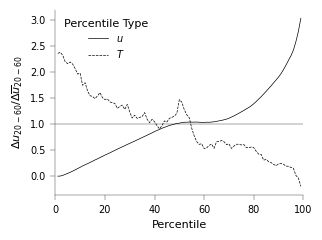

In [7]:
save_u_sf_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(((u_quant2[1] - u_quant2[0])/(u_mean[1]-u_mean[0])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use),
        color='k', label='$u$')
ax.plot(quant_plot, np.average(((u_quant3[1] - u_quant3[0])/(u_mean[1]-u_mean[0])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use),
        color='k', linestyle='--', label='$T$')
ax.hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax.set_xlim(0, 100)
# ax.set_ylim(0, 3)
ax.set_ylabel('$\Delta u_{20-60}/\Delta \overline{u}_{20-60}$')
ax.set_xlabel('Percentile')
ax.legend(title='Percentile Type', loc='upper left')

if save_fig or save_u_sf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_sf_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Percentile Relation: $x_u$ vs $x_T$
Below, I show the relationship between 200hPa zonal wind percentile, $x_u$ and near-surface temperature percentile, $x_T$. 

For $\kappa=1$, this is saying that 200hPa zonal winds associated with the $x_T=1$ percentile of near-surface temperature correspond to approximately the $x_u=69$ percentile of 200hPa zonal winds.

I.e. cold days are associated with fast winds, and with warming, the winds on cold days get relatively faster. Equally, hot days are associated with slow winds, and with warming, the winds on hot days get relatively slower.

In [8]:
u_temp_percentile = np.zeros((n_exp, n_lat, n_quant))              # percentile of u corresponding to each percentile of near-surface temp
with tqdm(total=n_exp*n_quant*len(lat_use), position=0, leave=True) as pbar:
    for i in range(n_exp):
        for k in range(n_lat):
            if k not in lat_use:
                continue
            use_ind = np.isfinite(u_func(ds_all[i].ucomp[-1, k]))           # ignore nan values, when consider summer only
            for j in range(n_quant):
                u_temp_percentile[i, k, j] = percentileofscore(u_func(ds_all[i].ucomp[-1, k])[use_ind], u_quant3[i, k, j])
                pbar.update(1)

100%|██████████| 5940/5940 [00:18<00:00, 327.13it/s]


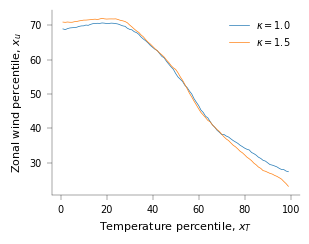

In [9]:
save_u_percentile_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(quant_plot, np.average(u_temp_percentile[i, lat_use], axis=0, weights=lat_weights_use), color=default_colors[i],
            label='$\kappa={:.1f}$'.format(tau_lw[i]))
ax.legend()
ax.set_xlabel('Temperature percentile, $x_T$')
ax.set_ylabel('Zonal wind percentile, $x_u$')

if save_fig or save_u_percentile_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_percentile_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Figure 1a
The solid line below, replicates Figure 1a showing how the changes in the $x_u=99$ percentile of $u$ varies with latitude. It matches fairly well the results in the paper, except in the tropics.

The dashed line shows changes in $u$ conditioned on the $x_T=1$ percentile of near-surface temperature. From above, we expect this to be fairly similar to the solid line. This has much larger variation with latitude, but does $u$ does seem to increase at all latitudes outside the tropics.

In [10]:
quant2_lat_use = 99
quant3_lat_use = 1
u_quant2_lat = np.zeros((n_exp, n_lat))
u_quant3_lat = np.zeros((n_exp, n_lat))
temp_global_mean = np.zeros(n_exp)

with tqdm(total=n_exp*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_global_mean[i] = area_weighting(ds_all[i].temp[0]).mean(skipna=True)
        u_quant2_lat[i] = u_func(ds_all[i].ucomp[-1]).quantile(quant2_lat_use/100, dim='lon_time', keep_attrs=True, skipna=True)
        for k in range(n_lat):
            use_ind = get_quant_ind(ds_all[i].temp[0, k], quant3_lat_use, 0.5, 0.5)
            u_quant3_lat[i, k] = u_func(ds_all[i].ucomp[-1, k, use_ind]).mean(skipna=True)                    
            pbar.update(1)

100%|██████████| 128/128 [00:01<00:00, 83.17it/s] 


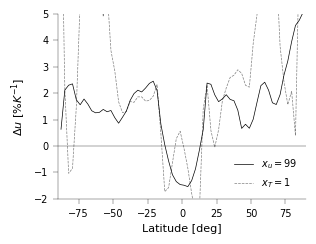

In [11]:
save_u_lat_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(ds_all[0].lat, 100*(u_quant2_lat[1]-u_quant2_lat[0])/(temp_global_mean[1]-temp_global_mean[0])/u_quant2_lat[0], color='k',
        label=f'$x_u={quant2_lat_use}$')
ax.plot(ds_all[0].lat, 100*(u_quant3_lat[1]-u_quant3_lat[0])/(temp_global_mean[1]-temp_global_mean[0])/u_quant3_lat[0], color='k',
        linestyle='--', alpha=0.5, label=f'$x_T={quant3_lat_use}$')
ax.hlines(0,-90,90, color='k', linewidth=ax_linewidth)
ax.set_xlim(-90, 90)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('$\Delta u$ [$\%K^{-1}$]')
ax.legend()
ax.set_ylim(-2, 5)

if save_fig or save_u_lat_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_lat_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Thermal Wind
Below, I replicate much of the results above, but with the thermal wind $u_T$, and moist thermal wind $u_{Tm}$. In general, there seems to be a good agreement between changes in the simulated $u$ and the computed $u_T$ and $u_{Tm}$.

In [12]:
def get_u_thermal(ds):
    # Axis 0 is pressure, axis 1 is latitude and axis 2 is lon_time
    # Equation 1 in the paper
    pressure = ds.pfull.to_numpy() * 100
    f_coriolis = 2 * rot_earth * np.sin(np.deg2rad(ds_all[0].lat).to_numpy())
    integrand = np.gradient(ds.temp, np.deg2rad(ds.lat), axis=1)/pressure[:, np.newaxis, np.newaxis]
    return scipy.integrate.simpson(integrand, pressure, axis=0) * R/(radius_earth * f_coriolis[:, np.newaxis])

def get_u_moist_thermal(ds):
    # Axis 0 is pressure, axis 1 is latitude and axis 2 is lon_time
    # Equation 2 in the paper
    pressure = ds.pfull*100
    moist_entropy = c_p * np.log(equivalent_potential_temp(ds.temp, pressure))
    dt_dp_moist = lapse_moist(ds.temp, pressure, True)
    f_coriolis = 2 * rot_earth * np.sin(np.deg2rad(ds_all[0].lat).to_numpy())
    integrand = dt_dp_moist * np.gradient(moist_entropy, np.deg2rad(ds.lat), axis=1)
    return scipy.integrate.simpson(integrand, pressure, axis=0) / (radius_earth * f_coriolis[:, np.newaxis])

In [13]:
u_thermal = np.asarray([get_u_thermal(ds_all[i]) for i in range(n_exp)])
u_thermal_moist = np.asarray([get_u_moist_thermal(ds_all[i]) for i in range(n_exp)])

In [14]:
u_thermal_mean = np.zeros((n_exp, n_lat))
u_thermal_quant2 = np.zeros((n_exp, n_lat, n_quant))
u_thermal_quant3 = np.zeros((n_exp, n_lat, n_quant))

u_thermal_moist_mean = np.zeros((n_exp, n_lat))
u_thermal_moist_quant2 = np.zeros((n_exp, n_lat, n_quant))
u_thermal_moist_quant3 = np.zeros((n_exp, n_lat, n_quant))

with tqdm(total=n_exp*n_quant*len(lat_use), position=0, leave=True) as pbar:
    for i in range(n_exp):
        # Mean calc here will give error when using summer because in tropics, when cross equator, can't take meridional gradient
        # in u_thermal calculation because only summer values are kept in either hemisphere.
        u_thermal_mean[i] = np.nanmean(u_func(u_thermal[i]), axis=1)
        u_thermal_quant2[i] = np.nanquantile(u_func(u_thermal[i]), quant_plot/100, axis=-1).transpose()
        u_thermal_moist_mean[i] = np.nanmean(u_func(u_thermal_moist[i]), axis=1)
        u_thermal_moist_quant2[i] = np.nanquantile(u_func(u_thermal_moist[i]), quant_plot/100, axis=-1).transpose()
        for k in range(n_lat):
            if k not in lat_use:
                continue
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_all[i].temp[0, k], quant, 0.5, 0.5)
                u_thermal_quant3[i, k, j] = np.nanmean(u_func(u_thermal[i, k, use_ind]))  
                u_thermal_moist_quant3[i, k, j] = np.nanmean(u_func(u_thermal_moist[i, k, use_ind]))
                pbar.update(1)
                
u_thermal_quant2_lat = np.zeros((n_exp, n_lat))
u_thermal_quant3_lat = np.zeros((n_exp, n_lat))
u_thermal_moist_quant2_lat = np.zeros((n_exp, n_lat))
u_thermal_moist_quant3_lat = np.zeros((n_exp, n_lat))

with tqdm(total=n_exp*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        u_thermal_quant2_lat[i] = np.nanquantile(u_func(u_thermal[i]), quant2_lat_use/100, axis=-1)
        u_thermal_moist_quant2_lat[i] = np.nanquantile(u_func(u_thermal_moist[i]), quant2_lat_use/100, axis=-1)
        for k in range(n_lat):
            use_ind = get_quant_ind(ds_all[i].temp[0, k], quant3_lat_use, 0.5, 0.5)
            u_thermal_quant3_lat[i, k] = np.nanmean(u_func(u_thermal[i, k, use_ind]))
            u_thermal_moist_quant3_lat[i, k] = np.nanmean(u_func(u_thermal_moist[i, k, use_ind]))
            pbar.update(1)

100%|██████████| 128/128 [00:01<00:00, 70.44it/s]


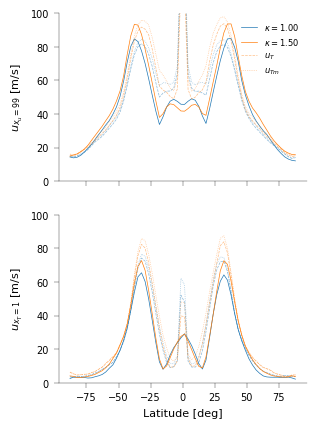

In [15]:
save_u_thermal_lat_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_exp):
    ax[0].plot(ds_all[0].lat, u_quant2_lat[i], color=default_colors[i], label='$\kappa={:.2f}$'.format(tau_lw[i]))
    ax[0].plot(ds_all[0].lat, u_thermal_quant2_lat[i], color=default_colors[i], linestyle='--', alpha=0.5, label='$u_T$' if i==1 else None)
    ax[0].plot(ds_all[0].lat, u_thermal_moist_quant2_lat[i], color=default_colors[i], linestyle=':', alpha=0.5, 
               label='$u_{Tm}$' if i==1 else None)
    ax[1].plot(ds_all[0].lat, u_quant3_lat[i], color=default_colors[i])
    ax[1].plot(ds_all[0].lat, u_thermal_quant3_lat[i], color=default_colors[i], linestyle='--', alpha=0.5)
    ax[1].plot(ds_all[0].lat, u_thermal_moist_quant3_lat[i], color=default_colors[i], linestyle=':', alpha=0.5)
ax[0].set_ylim(0, 100)
ax[0].legend(fontsize=6, loc='upper right')
ax[0].set_ylabel('$u_{x_u=99}$ [m/s]')
ax[1].set_ylabel('$u_{x_T=1}}$ [m/s]')
ax[-1].set_xlabel('Latitude [deg]')
if save_fig or save_u_thermal_lat_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_thermal_lat_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

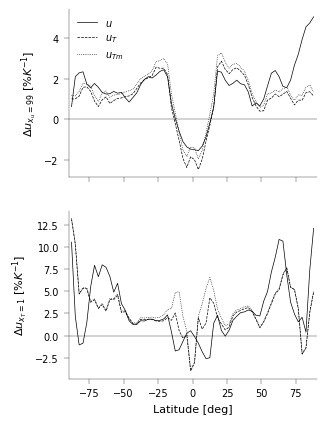

In [16]:
save_delta_u_thermal_lat_fig = False

fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2 * width['one_col']/ar), sharex=True)
ax[0].plot(ds_all[0].lat, 100*(u_quant2_lat[1]-u_quant2_lat[0])/(temp_global_mean[1]-temp_global_mean[0])/u_quant2_lat[0], 
           color='k', label='$u$')
ax[0].plot(ds_all[0].lat, 
           100*(u_thermal_quant2_lat[1]-u_thermal_quant2_lat[0])/(temp_global_mean[1]-temp_global_mean[0])/u_thermal_quant2_lat[0], 
           color='k', label='$u_T$', linestyle='--')
ax[0].plot(ds_all[0].lat, 
           100*(u_thermal_moist_quant2_lat[1]-u_thermal_moist_quant2_lat[0])/(temp_global_mean[1]-
                                                                              temp_global_mean[0])/u_thermal_moist_quant2_lat[0], 
           color='k', label='$u_{Tm}$', linestyle=':')

ax[1].plot(ds_all[0].lat, 100*(u_quant3_lat[1]-u_quant3_lat[0])/(temp_global_mean[1]-temp_global_mean[0])/u_quant3_lat[0], color='k')
ax[1].plot(ds_all[0].lat, 
           100*(u_thermal_quant3_lat[1]-u_thermal_quant3_lat[0])/(temp_global_mean[1]-temp_global_mean[0])/u_thermal_quant3_lat[0], 
           color='k', linestyle='--')
ax[1].plot(ds_all[0].lat, 
           100*(u_thermal_moist_quant3_lat[1]-u_thermal_moist_quant3_lat[0])/(temp_global_mean[1]-
                                                                              temp_global_mean[0])/u_thermal_moist_quant3_lat[0], 
           color='k', linestyle=':')

ax[0].hlines(0,-90,90, color='k', linewidth=ax_linewidth)
ax[1].hlines(0,-90,90, color='k', linewidth=ax_linewidth)
ax[0].set_xlim(-90, 90)
ax[-1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('$\Delta u_{x_u=99}$ [$\%K^{-1}$]')
ax[1].set_ylabel('$\Delta u_{x_T=1}$ [$\%K^{-1}$]')
ax[0].legend()
# ax[0].set_ylim(-3, 5)
# ax[1].set_ylim(-4, 20)

if save_fig or save_delta_u_thermal_lat_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_delta_thermal_lat_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

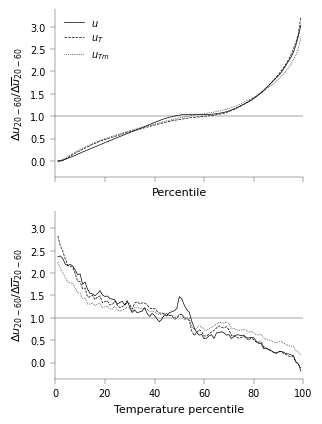

In [17]:
save_u_thermal_sf_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2 * width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(((u_quant2[1] - u_quant2[0])/(u_mean[1]-u_mean[0])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use),
           color='k', label='$u$')
ax[0].plot(quant_plot, np.average(((u_thermal_quant2[1] - u_thermal_quant2[0])/(u_thermal_mean[1]-u_thermal_mean[0])[:, np.newaxis])[lat_use],
                                  axis=0, weights=lat_weights_use), color='k', label='$u_T$', linestyle='--')
ax[0].plot(quant_plot, np.average(((u_thermal_moist_quant2[1] - u_thermal_moist_quant2[0])/(u_thermal_moist_mean[1]-
                                                                                            u_thermal_moist_mean[0])[:, np.newaxis])[lat_use],
                                  axis=0, weights=lat_weights_use), color='k', label='$u_{Tm}$', linestyle=':')

ax[1].plot(quant_plot, np.average(((u_quant3[1] - u_quant3[0])/(u_mean[1]-u_mean[0])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use),
           color='k')
ax[1].plot(quant_plot, np.average(((u_thermal_quant3[1] - u_thermal_quant3[0])/(u_thermal_mean[1]-u_thermal_mean[0])[:, np.newaxis])[lat_use], 
                                  axis=0, weights=lat_weights_use), color='k', linestyle='--')
ax[1].plot(quant_plot, np.average(((u_thermal_moist_quant3[1] - u_thermal_moist_quant3[0])/(u_thermal_moist_mean[1]-
                                                                                            u_thermal_moist_mean[0])[:, np.newaxis])[lat_use], 
                                  axis=0, weights=lat_weights_use), color='k', linestyle=':')
# ax.plot(quant_plot, np.average(((u_quant3[1] - u_quant3[0])/(u_mean[1]-u_mean[0])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use),
#         color='k', linestyle='--', label='$T$')
ax[0].hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax[1].hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax[0].set_xlim(0, 100)
# ax[0].set_ylim(0, 3)
ax[0].set_ylabel('$\Delta u_{20-60}/\Delta \overline{u}_{20-60}$')
ax[1].set_ylabel('$\Delta u_{20-60}/\Delta \overline{u}_{20-60}$')
ax[0].set_xlabel('Percentile')
ax[1].set_xlabel('Temperature percentile')
ax[0].legend(loc='upper left')

if save_fig or save_u_thermal_sf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_thermal_sf_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [80]:
pressure_ft_range = ds_all[0].pfull.sel(pfull=[600, 400, 200], method='nearest')        # choose 3 pressure levels
n_pressure_ft = len(pressure_ft_range)
temp_ft_mean = np.zeros((n_exp, n_pressure_ft, n_lat))
temp_ft_quant3 = np.zeros((n_exp, n_pressure_ft, n_lat, n_quant))
z_ft_mean = np.zeros((n_exp, n_pressure_ft, n_lat))
z_ft_quant3 = np.zeros((n_exp, n_pressure_ft, n_lat, n_quant))

with tqdm(total=n_exp*n_quant*len(lat_use), position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_all[i].sel(pfull=pressure_ft_range)             # don't consider all pressure values
        temp_ft_mean[i] = ds_use.temp.mean(dim='lon_time')
        z_ft_mean[i] = ds_use.height.mean(dim='lon_time')
        for k in range(n_lat):
            if k not in lat_use:
                continue
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_all[i].temp[0, k], quant, 0.5, 0.5)
                temp_ft_quant3[i, :, k, j] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                z_ft_quant3[i, :, k, j] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                pbar.update(1)

100%|██████████| 5940/5940 [00:49<00:00, 121.10it/s]


Text(0, 0.5, '$\\delta T/\\delta \\overline{T}$')

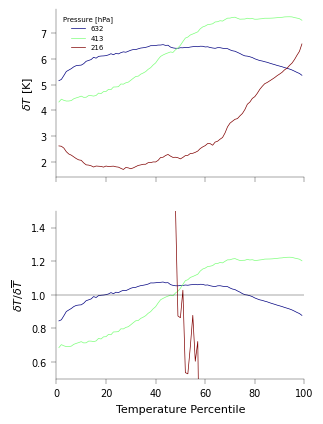

In [133]:
color_seq_pressure = plt.cm.jet(np.linspace(0,1,n_pressure_ft))
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_pressure_ft):
    ax[0].plot(quant_plot, np.average((temp_ft_quant3[1, i] - temp_ft_quant3[0, i])[lat_use], axis=0, weights=lat_weights_use),
               color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    ax[1].plot(quant_plot, np.average(((temp_ft_quant3[1, i] - temp_ft_quant3[0, i])/(temp_ft_mean[1, i]-temp_ft_mean[0, i])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use),
               color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
ax[1].hlines(1, 0, 100, color='k', lw=ax_linewidth)
ax[0].set_xlim(0, 100)
ax[0].legend(fontsize=5, title='Pressure [hPa]', title_fontsize=5)
ax[1].set_ylim(0.5, 1.5)
ax[-1].set_xlabel('Temperature Percentile')
ax[0].set_ylabel('$\delta T$ [K]')
ax[1].set_ylabel('$\delta T/\delta \overline{T}$')

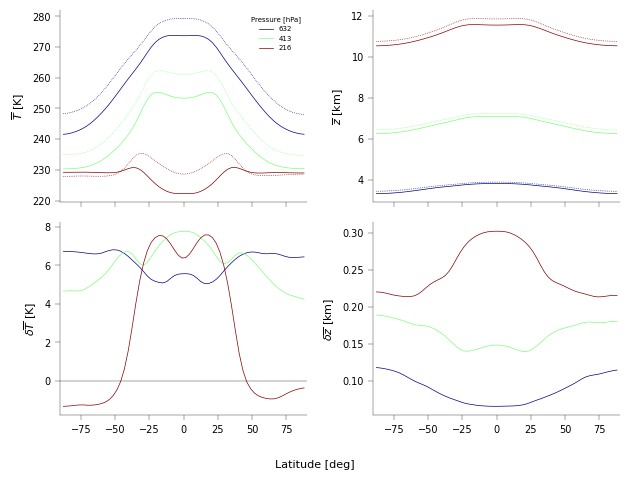

In [85]:
save_T_z_ft_mean_fig = False

fig, ax = plt.subplots(2,2, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_pressure_ft):
    ax[0, 0].plot(ds_all[0].lat, temp_ft_mean[0, i], color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    ax[0, 0].plot(ds_all[0].lat, temp_ft_mean[1, i], color=color_seq_pressure[i], linestyle=':')
    ax[1, 0].plot(ds_all[0].lat, temp_ft_mean[1, i]-temp_ft_mean[0, i], color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    
    ax[0, 1].plot(ds_all[0].lat, z_ft_mean[0, i]/1000, color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    ax[0, 1].plot(ds_all[0].lat, z_ft_mean[1, i]/1000, color=color_seq_pressure[i], linestyle=':')
    ax[1, 1].plot(ds_all[0].lat, (z_ft_mean[1, i]-z_ft_mean[0, i])/1000, color=color_seq_pressure[i])
ax[1, 0].hlines(0, -90, 90, color='k', lw=ax_linewidth)
ax[0, 0].set_xlim(-90, 90)
ax[0, 0].legend(fontsize=5, title='Pressure [hPa]', title_fontsize=5)
fig.supxlabel('Latitude [deg]', fontsize=8)
ax[0, 0].set_ylabel('$\overline{T}$ [K]')
ax[0, 1].set_ylabel('$\overline{z}$ [km]')
ax[1, 0].set_ylabel('$\delta \overline{T}$ [K]')
ax[1, 1].set_ylabel('$\delta \overline{z}$ [km]')
plt.tight_layout()

if save_fig or save_T_z_ft_mean_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/T_z_ft_mean_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

Text(0, 0.5, '$\\delta z/\\delta \\overline{z}$')

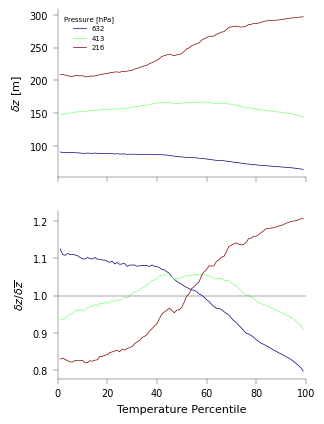

In [130]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_pressure_ft):
    ax[0].plot(quant_plot, np.average((z_ft_quant3[1, i] - z_ft_quant3[0, i])[lat_use], axis=0, weights=lat_weights_use),
               color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    ax[1].plot(quant_plot, np.average(((z_ft_quant3[1, i] - z_ft_quant3[0, i])/(z_ft_mean[1, i]-z_ft_mean[0, i])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use),
               color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
ax[1].hlines(1, 0, 100, color='k', lw=ax_linewidth)
ax[0].set_xlim(0, 100)
ax[0].legend(fontsize=5, title='Pressure [hPa]', title_fontsize=5)
ax[-1].set_xlabel('Temperature Percentile')
ax[0].set_ylabel('$\delta z$ [m]')
ax[1].set_ylabel('$\delta z/\delta \overline{z}$')

In [71]:
# Load in dataset to compute the gradient
# keep 'lon' and 'time' separate. And only keep pressure levels in above plot as well as only height and temp
ds_gradient = []        
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(pfull=pressure_ft_range).sel(time=slice(use_time_start, np.inf))[['height', 'temp']]
        # ds_use = ds_use.isel(pfull=slice(None, None, -1))       # make surface pressure the first index
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.transpose('pfull', 'lat', 'lon', 'time')        # make time the last index
        ds_gradient += [ds_use.load()]
        pbar.update(1)

100%|██████████| 2/2 [00:12<00:00,  6.28s/it]


In [72]:
def get_gradient(var, lon, lat):
    # Returns d/dx and d/dy
    # Axis 0 is pressure, axis 1 is latitude, axis 2 is lon and axis 3 is time
    lon = np.asarray(np.deg2rad(lon))
    lat = np.asarray(np.deg2rad(lat))
    d_var_dx = (1/radius_earth*np.cos(lat)[np.newaxis, :, np.newaxis, np.newaxis]) * np.gradient(var, lon, axis=2)
    d_var_dy = (1/radius_earth) * np.gradient(var, lat, axis=1)
    return d_var_dx, d_var_dy

In [73]:
d_temp_dx = np.zeros((n_exp, n_pressure_ft, n_lat, len(ds_gradient[0].lon), len(ds_gradient[0].time)))
d_temp_dy = np.zeros((n_exp, n_pressure_ft, n_lat, len(ds_gradient[0].lon), len(ds_gradient[0].time)))
for i in tqdm(range(n_exp)):
    d_temp_dx[i], d_temp_dy[i] = get_gradient(ds_gradient[i].temp, ds_gradient[i].lon, ds_gradient[i].lat)
# Stack lon and lat coordinates again, so same dimensions as ds_all
d_temp_dx = d_temp_dx.reshape((n_exp, n_pressure_ft, n_lat, -1))
d_temp_dy = d_temp_dy.reshape((n_exp, n_pressure_ft, n_lat, -1))

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


In [103]:
# Sanity check that the method of re-ordering is the same as it is when stacking in lon_time
a = ds_gradient[0].temp.sel(pfull=[200, 400], lat=[-30, 0, 60], method='nearest')
a = a.to_numpy().reshape(2, 3, -1) - ds_all[0].temp.sel(pfull=[200, 400], lat=[-30, 0, 60], method='nearest').to_numpy()
a = np.abs(a).max()
print(a)

0.0


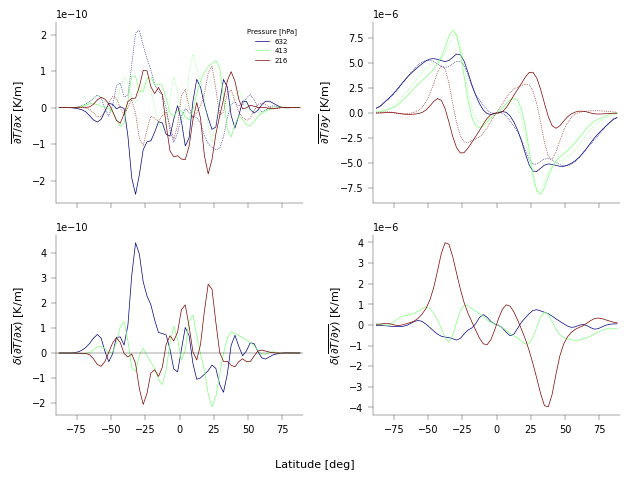

In [78]:
save_T_gradient_mean_fig = False

fig, ax = plt.subplots(2,2, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_pressure_ft):
    var_use = d_temp_dx.mean(axis=-1)
    ax[0, 0].plot(ds_all[0].lat, var_use[0, i], color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    ax[0, 0].plot(ds_all[0].lat, var_use[1, i], color=color_seq_pressure[i], linestyle=':')
    ax[1, 0].plot(ds_all[0].lat, var_use[1, i]-var_use[0, i], color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    
    var_use = d_temp_dy.mean(axis=-1)
    ax[0, 1].plot(ds_all[0].lat, var_use[0, i], color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    ax[0, 1].plot(ds_all[0].lat, var_use[1, i], color=color_seq_pressure[i], linestyle=':')
    ax[1, 1].plot(ds_all[0].lat, (var_use[1, i]-var_use[0, i]), color=color_seq_pressure[i])
ax[1, 0].hlines(0, -90, 90, color='k', lw=ax_linewidth)
ax[0, 0].set_xlim(-90, 90)
ax[0, 0].legend(fontsize=5, title='Pressure [hPa]', title_fontsize=5)
fig.supxlabel('Latitude [deg]', fontsize=8)
ax[0, 0].set_ylabel('$\overline{\partial T/\partial x}$ [K/m]')
ax[0, 1].set_ylabel('$\overline{\partial T/\partial y}$ [K/m]')
ax[1, 0].set_ylabel('$\delta (\overline{\partial T/\partial x})$ [K/m]')
ax[1, 1].set_ylabel('$\delta (\overline{\partial T/\partial y})$ [K/m]')
plt.tight_layout()

if save_fig or save_T_gradient_mean_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/T_gradient_mean_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [115]:
d_temp_dx_quant3 = np.zeros((n_exp, n_pressure_ft, n_lat, n_quant))
d_temp_dy_quant3 = np.zeros((n_exp, n_pressure_ft, n_lat, n_quant))

with tqdm(total=n_exp*n_quant*len(lat_use), position=0, leave=True) as pbar:
    for i in range(n_exp):
        for k in range(n_lat):
            if k not in lat_use:
                continue
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_all[i].temp[0, k], quant, 0.5, 0.5)
                # Need axis 0 here because for some reason it transposes
                d_temp_dx_quant3[i, :, k, j] = np.mean(d_temp_dx[i, :, k, use_ind], axis=0)
                d_temp_dy_quant3[i, :, k, j] = np.mean(d_temp_dy[i, :, k, use_ind], axis=0)
                pbar.update(1)

100%|██████████| 5940/5940 [00:45<00:00, 129.34it/s]


Text(0, 0.5, '$\\delta (\\partial T/\\partial x) / \\delta (\\overline{\\partial T/\\partial x})$')

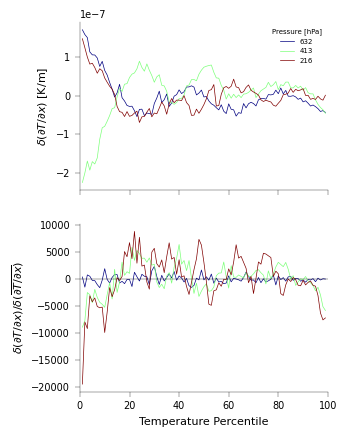

In [137]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_pressure_ft):
    ax[0].plot(quant_plot, np.average((d_temp_dx_quant3[1, i] - d_temp_dx_quant3[0, i])[lat_use], axis=0, weights=lat_weights_use),
               color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    ax[1].plot(quant_plot, np.average(((d_temp_dx_quant3[1, i] - d_temp_dx_quant3[0, i])/(d_temp_dx.mean(axis=-1)[1, i]-d_temp_dx.mean(axis=-1)[0, i])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use), color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
ax[1].hlines(1, 0, 100, color='k', lw=ax_linewidth)
ax[0].set_xlim(0, 100)
ax[0].legend(fontsize=5, title='Pressure [hPa]', title_fontsize=5)
ax[-1].set_xlabel('Temperature Percentile')
ax[0].set_ylabel('$\delta (\partial T/\partial x)$ [K/m]')
ax[1].set_ylabel('$\delta (\partial T/\partial x) / \delta (\overline{\partial T/\partial x})$')

Text(0, 0.5, '$\\delta (\\partial T/\\partial y) / \\delta (\\overline{\\partial T/\\partial y})$')

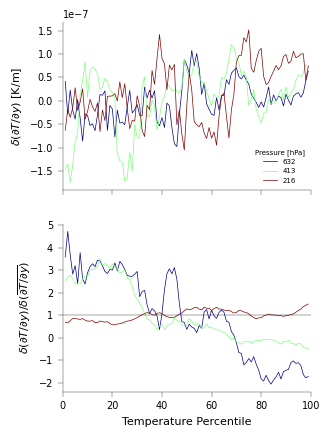

In [136]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_pressure_ft):
    ax[0].plot(quant_plot, np.average((d_temp_dy_quant3[1, i] - d_temp_dy_quant3[0, i])[lat_use], axis=0, weights=lat_weights_use),
               color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    ax[1].plot(quant_plot, np.average(((d_temp_dy_quant3[1, i] - d_temp_dy_quant3[0, i])/(d_temp_dy.mean(axis=-1)[1, i]-d_temp_dy.mean(axis=-1)[0, i])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use), color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
ax[1].hlines(1, 0, 100, color='k', lw=ax_linewidth)
ax[0].set_xlim(0, 100)
ax[0].legend(fontsize=5, title='Pressure [hPa]', title_fontsize=5)
ax[-1].set_xlabel('Temperature Percentile')
ax[0].set_ylabel('$\delta (\partial T/\partial y)$ [K/m]')
ax[1].set_ylabel('$\delta (\partial T/\partial y) / \delta (\overline{\partial T/\partial y})$')

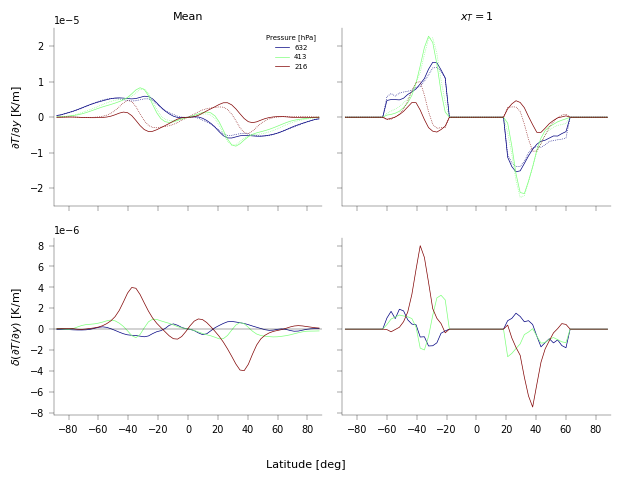

In [144]:
save_T_gradient_mean_fig = False

fig, ax = plt.subplots(2,2, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True, sharey='row')
for i in range(n_pressure_ft):
    var_use = d_temp_dy.mean(axis=-1)
    ax[0, 0].plot(ds_all[0].lat, var_use[0, i], color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    ax[0, 0].plot(ds_all[0].lat, var_use[1, i], color=color_seq_pressure[i], linestyle=':')
    ax[1, 0].plot(ds_all[0].lat, var_use[1, i]-var_use[0, i], color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    
    var_use = d_temp_dy_quant3[:, :, :, quant3_lat_use]
    ax[0, 1].plot(ds_all[0].lat, var_use[0, i], color=color_seq_pressure[i], label=int(pressure_ft_range[i]))
    ax[0, 1].plot(ds_all[0].lat, var_use[1, i], color=color_seq_pressure[i], linestyle=':')
    ax[1, 1].plot(ds_all[0].lat, (var_use[1, i]-var_use[0, i]), color=color_seq_pressure[i])
ax[1, 0].hlines(0, -90, 90, color='k', lw=ax_linewidth)
ax[0, 0].set_xlim(-90, 90)
ax[0, 0].legend(fontsize=5, title='Pressure [hPa]', title_fontsize=5)
fig.supxlabel('Latitude [deg]', fontsize=8)
ax[0, 0].set_ylabel('$\partial T/\partial y$ [K/m]')
ax[1, 0].set_ylabel('$\delta (\partial T/\partial y)$ [K/m]')
ax[0, 0].set_title('Mean')
ax[0, 1].set_title(f'$x_T={quant3_lat_use}$')
plt.tight_layout()

if save_fig or save_T_gradient_mean_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/T_gradient_mean_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)